### Import all libraries

In [1]:
from google.cloud import bigquery
from google.oauth2 import service_account
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from urllib.request import urlopen
import json
import os
import datetime
import plotly.express as px
from statsmodels.tsa.arima.model import ARIMA
import math
from sklearn.metrics import mean_squared_error
from pmdarima.arima import auto_arima
import datetime
import matplotlib.dates as dates
import statsmodels.api as sm
from datetime import datetime

### Access the  database

In [2]:
credentials = service_account.Credentials.from_service_account_file(
'./chain-coders-5d47d58b2c33.json')

project_id = 'chain-coders'
client = bigquery.Client(credentials= credentials,project=project_id)

datasets = client.list_datasets()
for dataset in datasets:
  did = dataset.dataset_id
  # Optional to verify that you are able to access the datasets.
  # The datasets we care about are mimiciii_clinical and mimiciii_notes.
  print(did)

redfin


## Using Pandas

In [35]:

query = "SELECT * FROM `redfin.redfin-data-county` "

In [36]:
type(query)

str

In [37]:
df = client.query(query).to_dataframe()

In [38]:
df.property_type_id.unique()

<IntegerArray>
[<NA>, 6, 3, -1, 13, 4]
Length: 6, dtype: Int64

In [39]:
df[['property_type_id','property_type']]

,property_type_id,property_type
0,<NA>,SFH
1,<NA>,SFH
2,<NA>,SFH
3,<NA>,SFH
4,<NA>,SFH
...,...,...
736119,3,Condo/Co-op
736120,4,Multi-Family (2-4 Unit)
736121,4,Multi-Family (2-4 Unit)
736122,3,Condo/Co-op


In [40]:
df_ppsf = df[['period_end','property_type_id','median_ppsf' ,'region' ]]

In [41]:
counties = df_ppsf.region.unique()

In [42]:
property_types = df_ppsf.property_type_id.unique()

In [43]:
property_types
#3  condo, 
#-1  all residential,
#6  single family,
#13 townhouse,
#4  multi family

<IntegerArray>
[<NA>, 6, 3, -1, 13, 4]
Length: 6, dtype: Int64

In [44]:
for county in counties[10:11]:
    mask1 = df['region'] ==county
    mask2 = df['property_type_id'] == 6
counties[10:11]

array(['Manassas, VA'], dtype=object)

In [45]:
df_ppsf

,period_end,property_type_id,median_ppsf,region
0,NaT,<NA>,1133.777300,test124
1,NaT,<NA>,1133.777300,test124
2,NaT,<NA>,1133.777300,test124
3,NaT,<NA>,1133.777300,test124
4,NaT,<NA>,1133.777300,test124
...,...,...,...,...
736119,2012-09-30,3,78.692494,"Fairbanks North Star Borough, AK"
736120,2021-02-28,4,158.173931,"Fairbanks North Star Borough, AK"
736121,2015-12-31,4,77.535714,"Fairbanks North Star Borough, AK"
736122,2015-06-30,3,74.634456,"Fairbanks North Star Borough, AK"


In [46]:
df_filtered = df_ppsf[mask1 & mask2]
df_filtered = df_filtered.set_index('period_end').sort_values(by=['period_end'])

df_filtered.index = pd.to_datetime(df_filtered.index)

df_filtered.index = df_filtered.index.to_period('M')

df_filtered

,property_type_id,median_ppsf,region
period_end,,,
2012-01,6,135.380372,"Manassas, VA"
2012-02,6,132.730504,"Manassas, VA"
2012-03,6,134.931481,"Manassas, VA"
2012-04,6,140.782123,"Manassas, VA"
2012-05,6,142.427121,"Manassas, VA"
...,...,...,...
2022-05,6,237.559918,"Manassas, VA"
2022-06,6,236.434109,"Manassas, VA"
2022-07,6,222.743259,"Manassas, VA"


In [47]:
arima_model = ARIMA(df_filtered.median_ppsf, order= (1,1,2))
model_fit = arima_model.fit ()
print (model_fit.summary ())

                               SARIMAX Results                                
Dep. Variable:            median_ppsf   No. Observations:                  129
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -514.815
Date:                Sat, 03 Dec 2022   AIC                           1037.631
Time:                        20:11:46   BIC                           1049.039
Sample:                    01-31-2012   HQIC                          1042.266
                         - 09-30-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9861      0.019     51.966      0.000       0.949       1.023
ma.L1         -1.9762      2.141     -0.923      0.356      -6.173       2.220
ma.L2          0.9994      2.166      0.461      0.6

/usr/local/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


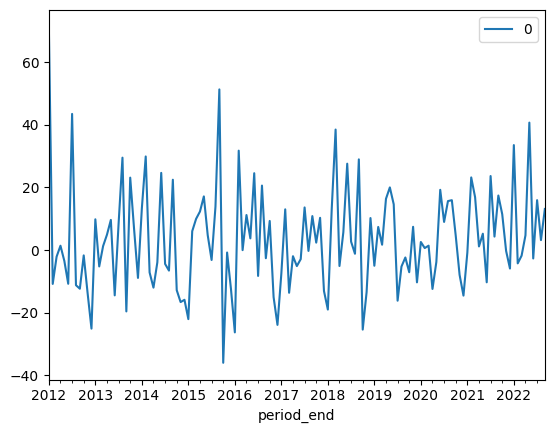

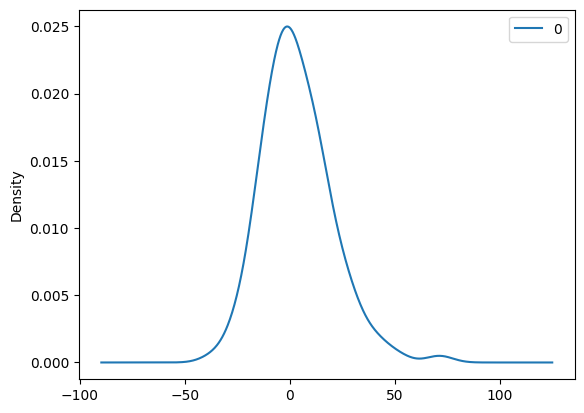

                0
count  129.000000
mean     3.522161
std     16.602515
min    -35.989105
25%     -7.148907
50%      1.379366
75%     13.037743
max     71.269575


In [16]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

[100.01445756]
[115.33884145]
[102.40210552]
[109.49017898]
[118.00926177]
[122.17817516]
[120.52941231]
[117.43094562]
[113.08052865]
[114.41083031]
[117.69680897]
[108.15912495]
[113.42076091]
[110.55676688]
[112.09619074]
[111.52143178]
[107.68529326]
[111.8004346]
[114.82741947]
[124.13394194]
[123.73439546]
[126.37850846]
[128.26491592]
[120.5292592]
[119.95819444]
[126.57869826]
[131.35693768]
[132.4805514]
[131.0970721]
[126.5600308]
[140.23158441]
[136.62670794]
[144.86712947]
[144.76916231]
[143.26162964]
[146.82420394]
[151.75518007]
[150.44959631]
[156.85168519]
[149.59281725]
[158.73729215]
[165.60147667]
[170.42581749]
[164.54582046]
Test RMSE: 13.921
period_end
2019-02    112.000000
2019-03    108.823645
2019-04    123.401712
2019-05    132.142857
2019-06    131.661294
2019-07    104.812941
2019-08    110.452586
2019-09    112.914795
2019-10    107.058824
2019-11    119.875549
2019-12    104.434907
2020-01    113.834423
2020-02    113.453370
2020-03    113.769227
2020-04 

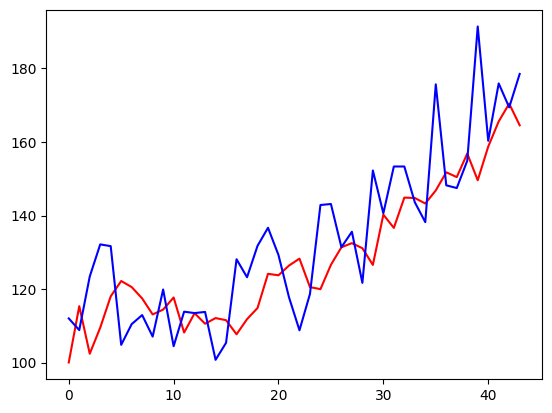

In [17]:
# split into train and test sets
X = df_filtered.median_ppsf
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
future = [x for x in test]
predictions = []
# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    print(output)
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = math.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
print(test)
#plt.plot(test)

#my_xticks = 
#plt.xticks(x, my_xticks)

plt.plot(predictions, color='red')
plt.plot(  future , color='blue')

plt.show()

In [18]:
df_sar = df_ppsf[mask1 & mask2]
df_sar = df_sar[['median_ppsf', 'period_end']]
df_sar = df_sar.set_index('period_end')
df_sar.index = pd.to_datetime(df_sar.index)
ts = df_sar.resample('m').mean()

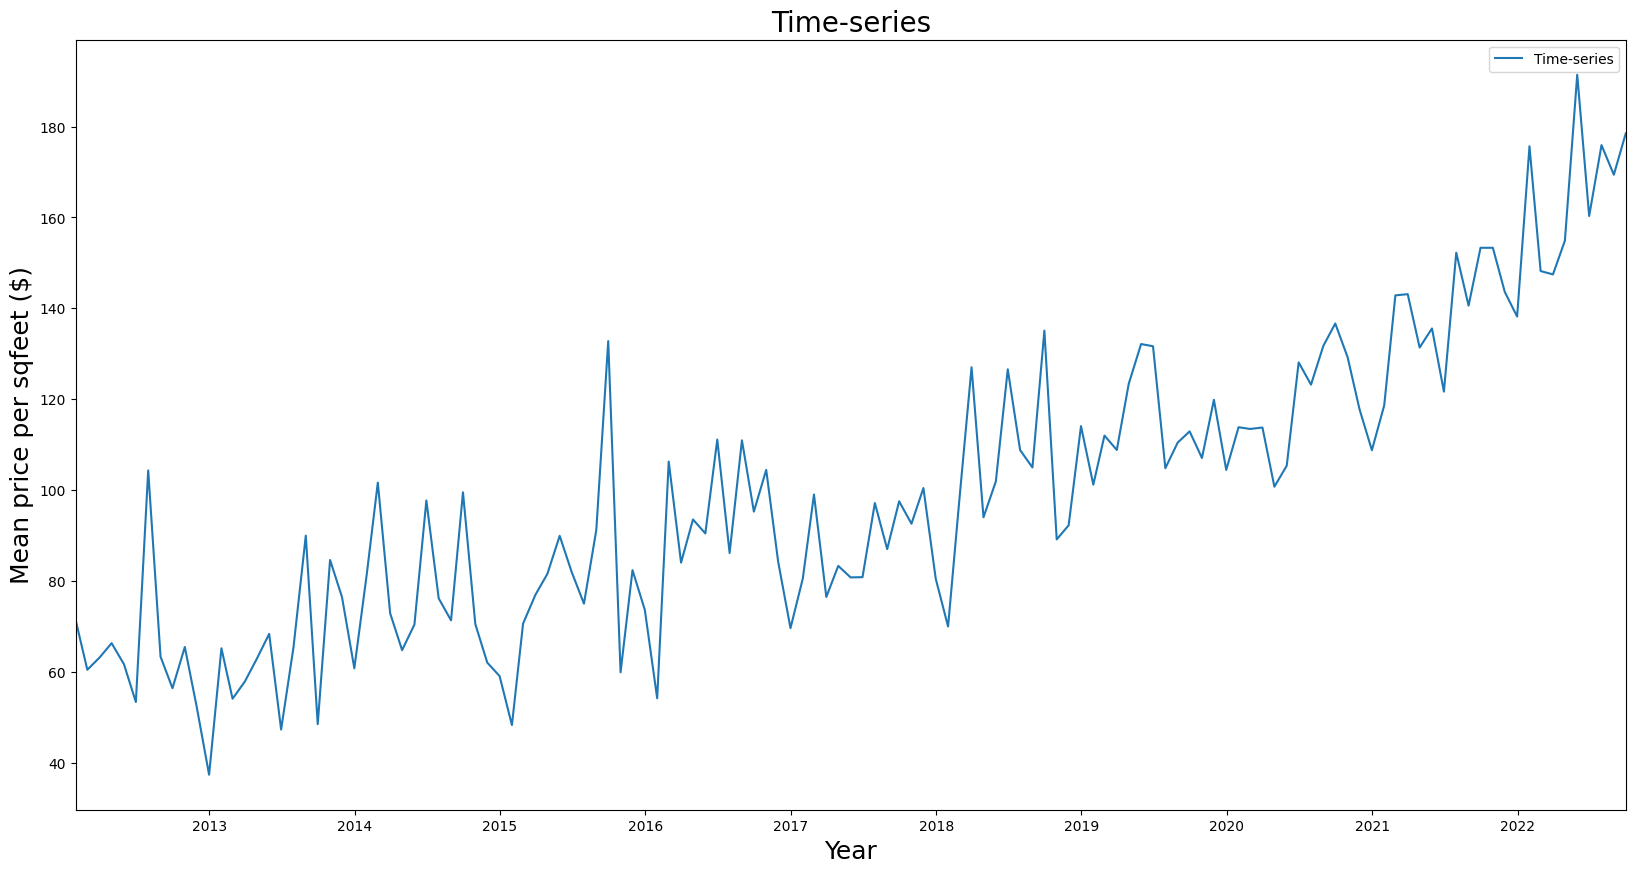

In [19]:
plt.figure(figsize=(20,10))
plt.plot(ts,label='Time-series')
plt.xlim(dates.date2num([ts.index[0], ts.index[-1]]))
plt.xlabel("Year", fontsize='18')
plt.ylabel("Mean price per sqfeet ($)", fontsize='18')
plt.title("Time-series", fontsize='20')

plt.legend(loc='best')
font = {'weight' : 'normal',
        'size'   : 16}
plt.rc('font', **font)
plt.show()

In [31]:
#Train-test split, 20 years of training data and 5 years of test data
ts_train=ts[ts.index[0]:( ts.index[ts.index.get_loc('2019-12-31', method='nearest')])]
ts_test=ts[ ts.index[ts.index.get_loc('2019-12-31', method='nearest')]:ts.index[-1]]

In [21]:
from pmdarima.arima import auto_arima
paramsearch=auto_arima(ts_train,start_p=2,d=None,start_q=1,max_p=7,max_d=1,max_q=5,start_P=1,D=1,start_Q=1,max_P=7,max_D=3,max_Q=7,m=12, trace=True,enforce_stationarity=False)

Performing stepwise search to minimize aic
 ARIMA(2,0,1)(1,1,1)[12] intercept   : AIC=724.407, Time=0.33 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=752.333, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=731.301, Time=0.10 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=760.091, Time=0.01 sec
 ARIMA(2,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(2,0,1)(1,1,0)[12] intercept   : AIC=734.103, Time=0.21 sec
 ARIMA(2,0,1)(2,1,1)[12] intercept   : AIC=725.756, Time=0.78 sec
 ARIMA(2,0,1)(1,1,2)[12] intercept   : AIC=inf, Time=0.79 sec
 ARIMA(2,0,1)(0,1,0)[12] intercept   : AIC=755.876, Time=0.07 sec
 ARIMA(2,0,1)(0,1,2)[12] intercept   : AIC=724.313, Time=0.62 sec
 ARIMA(2,0,1)(0,1,3)[12] intercept   : AIC=726.410, Time=0.70 sec
 ARIMA(2,0,1)(1,1,3)[12] intercept   : AIC=727.782, Time=1.58 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=722.934, Time=0.40 sec
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=in

 This problem is unconstrained.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.17534D+00    |proj g|=  3.90641D-02

At iterate    5    f=  4.16331D+00    |proj g|=  9.97922D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      5      8      1     0     0   9.979D-06   4.163D+00
  F =   4.1633135736494022     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


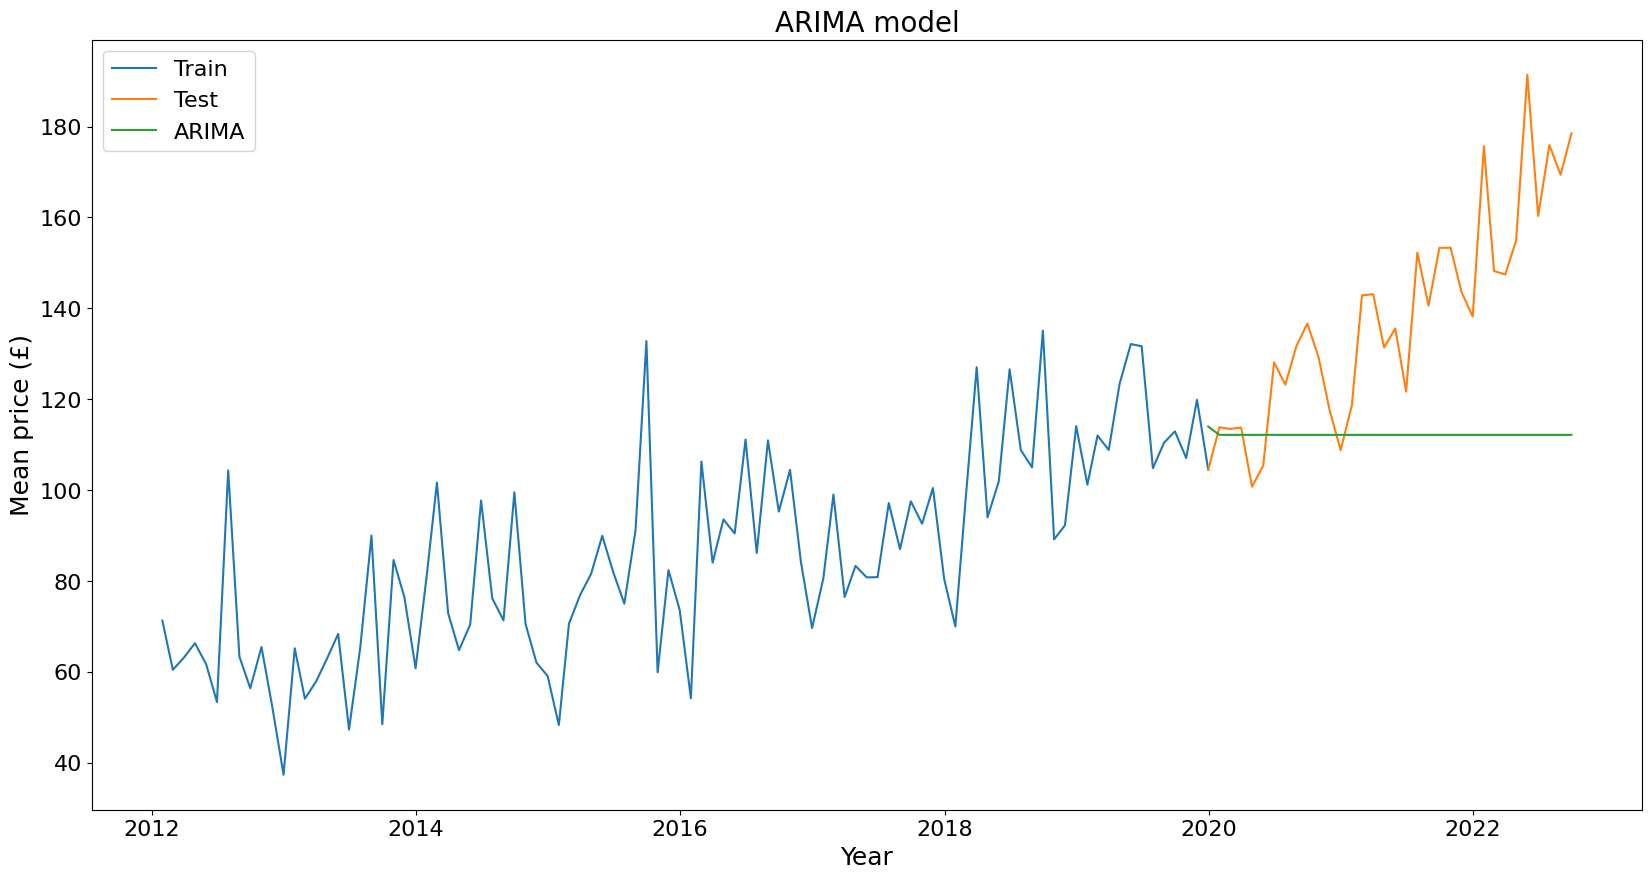

The Root Mean Squared Error of our forecasts is 34.8


In [22]:
#ARIMA
import statsmodels.api as sm
y_hat_avg = ts_test.copy()
fit1 = sm.tsa.statespace.SARIMAX(ts_train, order=(0, 1, 1),freq='m',seasonal_order=(0,0,0,0)).fit()
y_hat_avg['ARIMA'] = fit1.predict(start=ts_test.index[0],end=ts_test.index[-1])
plt.figure(figsize=(20,10))
plt.plot( ts_train, label='Train')
plt.plot(ts_test, label='Test')
plt.plot(y_hat_avg['ARIMA'], label='ARIMA')
plt.xlabel("Year", fontsize='18')
plt.ylabel("Mean price (£)", fontsize='18')
plt.title("ARIMA model", fontsize='20')

plt.legend(loc='best')
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}
plt.rc('font', **font)
plt.legend(loc='best')
plt.show()
rms = np.sqrt(mean_squared_error(ts_test, y_hat_avg.ARIMA))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rms, 1)))

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.88685D+00    |proj g|=  3.82819D-01

At iterate    5    f=  3.75372D+00    |proj g|=  3.89177D-02

At iterate   10    f=  3.70254D+00    |proj g|=  6.43254D-03

At iterate   15    f=  3.70048D+00    |proj g|=  1.64931D-03

At iterate   20    f=  3.70046D+00    |proj g|=  5.73654D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     23      1     0     0   7.815D-06   3.700D+00
  F =   3.7004614428614420     

CONVERG

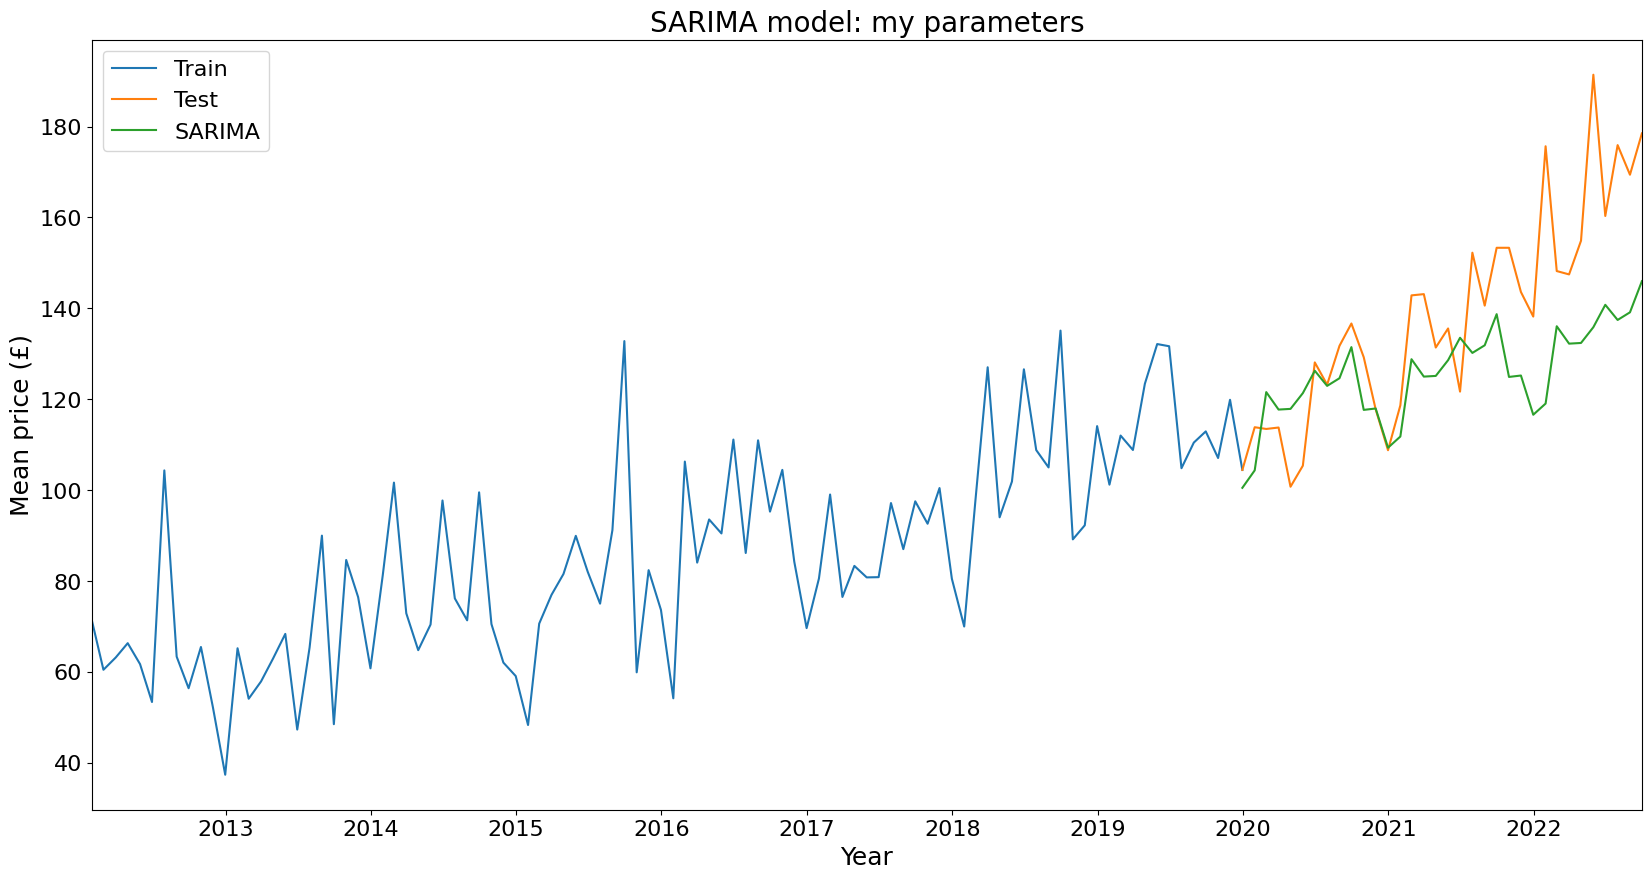

In [23]:
#SARIMA
y_hat_avg1 = ts_test.copy()
fit3 = sm.tsa.statespace.SARIMAX(ts_train, order=(1, 1, 1),seasonal_order=(0,1,1,12)).fit()
y_hat_avg1['SARIMA'] = fit3.predict(start=ts_test.index[0],end=ts_test.index[-1])
plt.figure(figsize=(20,10))
plt.plot( ts_train, label='Train')
plt.plot(ts_test, label='Test')
plt.plot(y_hat_avg1['SARIMA'], label='SARIMA')
plt.legend(loc='best')
plt.xlabel("Year", fontsize='18')
plt.xlim(dates.date2num([ts_train.index[0], ts_test.index[-1]]))
plt.ylabel("Mean price (£)", fontsize='18')
plt.title("SARIMA model: my parameters", fontsize='20')

plt.legend(loc='best')
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}
plt.rc('font', **font)
plt.show()

In [24]:
rms2 = np.sqrt(mean_squared_error(ts_test, y_hat_avg1.SARIMA))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rms2, 1)))

The Root Mean Squared Error of our forecasts is 21.1


In [32]:
#Creating a test date set of future dates
ts_test_future=ts_test
ts_test_future.index=ts_test_future.index+pd.DateOffset(years=3)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.87622D+00    |proj g|=  5.98340D-02

At iterate    5    f=  3.80104D+00    |proj g|=  2.26323D-02

At iterate   10    f=  3.78948D+00    |proj g|=  2.49506D-03

At iterate   15    f=  3.78872D+00    |proj g|=  2.47422D-03

At iterate   20    f=  3.78861D+00    |proj g|=  4.46962D-04

At iterate   25    f=  3.78860D+00    |proj g|=  1.34233D-03

At iterate   30    f=  3.78860D+00    |proj g|=  5.16214D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.


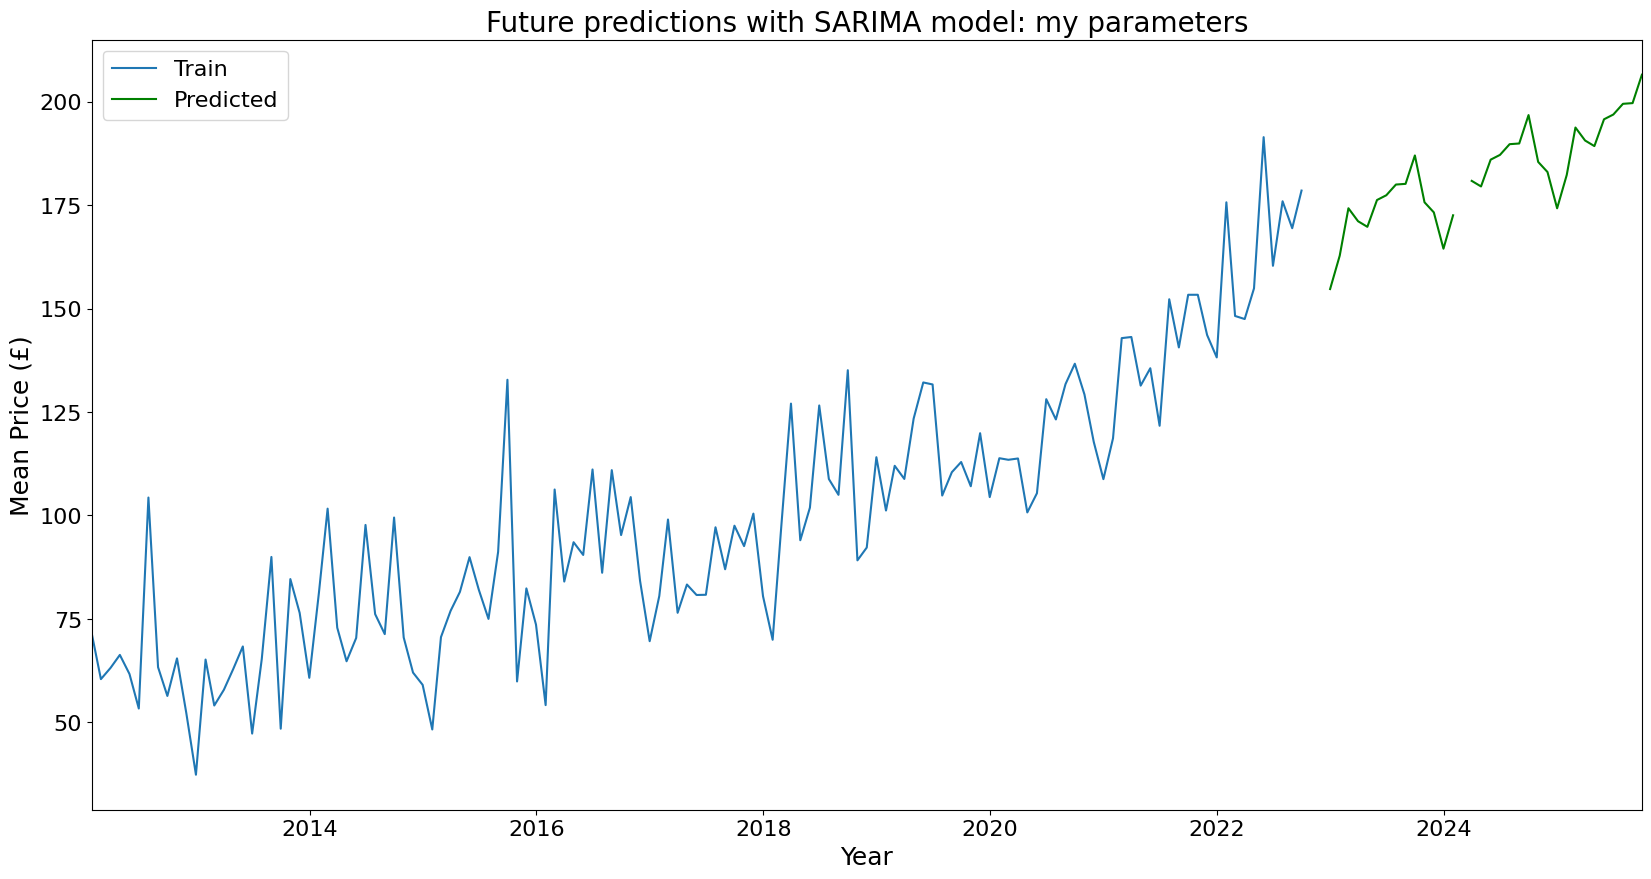

In [33]:
y_hat_avg_future = ts_test_future.copy()
fit_future = sm.tsa.statespace.SARIMAX(ts, order=(1, 1, 1),seasonal_order=(0,1,1,12)).fit()
y_hat_avg_future['SARIMA'] = fit_future.predict(start=ts_test_future.index[0],end=ts_test_future.index[-1])
plt.figure(figsize=(20,10))
plt.plot( ts, label='Train')
plt.plot(y_hat_avg_future['SARIMA'], label='Predicted', color='g')
plt.legend(loc='best')
plt.xlabel("Year", fontsize='18')
plt.xlim(dates.date2num([ts_train.index[0], ts_test_future.index[-1]]))
plt.ylabel("Mean Price (£)", fontsize='18')
plt.title("Future predictions with SARIMA model: my parameters", fontsize='20')

plt.legend(loc='best')
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}
plt.rc('font', **font)
plt.show()

In [36]:
#Train-test split, 20 years of training data and 5 years of test data
ts_train=ts[ts.index[0]:( ts.index[ts.index.get_loc('2016-12-31', method='nearest')])]
ts_test=ts[ ts.index[ts.index.get_loc('2016-12-31', method='nearest')]:ts.index[ts.index.get_loc('2019-12-31', method='nearest')]]

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.55571D+00    |proj g|=  2.99206D-01

At iterate    5    f=  3.48106D+00    |proj g|=  1.06578D-02

At iterate   10    f=  3.45574D+00    |proj g|=  4.56495D-02

At iterate   15    f=  3.45181D+00    |proj g|=  1.23140D-02

At iterate   20    f=  3.45050D+00    |proj g|=  1.12928D-03

At iterate   25    f=  3.45037D+00    |proj g|=  3.00880D-04

At iterate   30    f=  3.45036D+00    |proj g|=  1.87645D-04

At iterate   35    f=  3.45036D+00    |proj g|=  2.60943D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

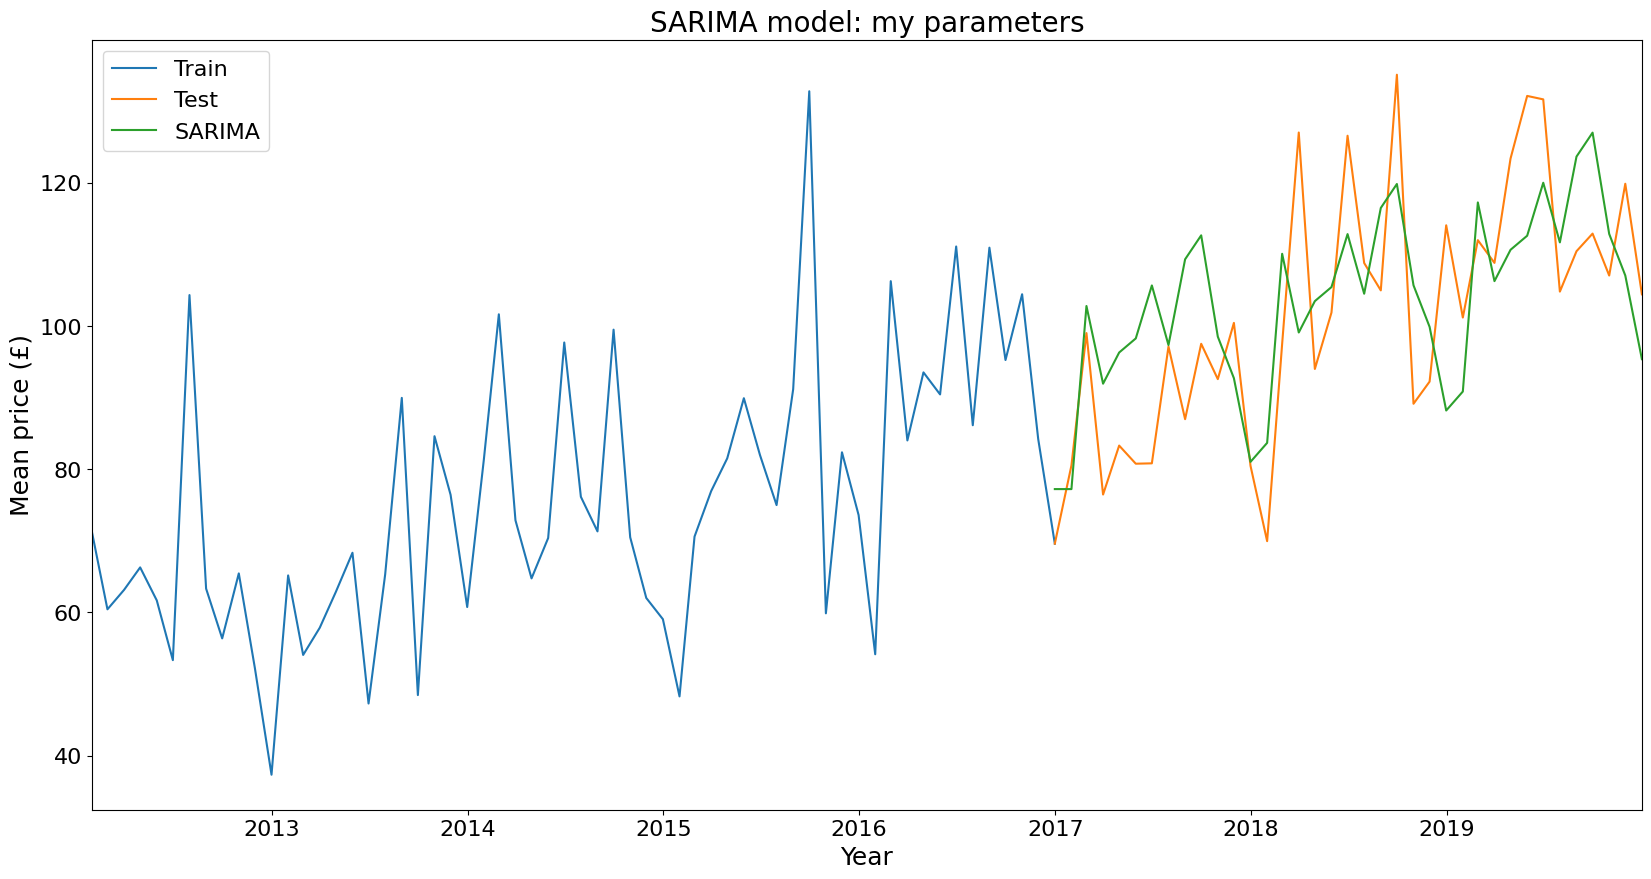

In [37]:
#SARIMA
y_hat_avg1 = ts_test.copy()
fit3 = sm.tsa.statespace.SARIMAX(ts_train, order=(1, 1, 1),seasonal_order=(0,1,1,12)).fit()
y_hat_avg1['SARIMA'] = fit3.predict(start=ts_test.index[0],end=ts_test.index[-1])
plt.figure(figsize=(20,10))
plt.plot( ts_train, label='Train')
plt.plot(ts_test, label='Test')
plt.plot(y_hat_avg1['SARIMA'], label='SARIMA')
plt.legend(loc='best')
plt.xlabel("Year", fontsize='18')
plt.xlim(dates.date2num([ts_train.index[0], ts_test.index[-1]]))
plt.ylabel("Mean price (£)", fontsize='18')
plt.title("SARIMA model: my parameters", fontsize='20')

plt.legend(loc='best')
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}
plt.rc('font', **font)
plt.show()

In [38]:
rms2 = np.sqrt(mean_squared_error(ts_test, y_hat_avg1.SARIMA))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rms2, 1)))

The Root Mean Squared Error of our forecasts is 13.3
